In [2]:
# 設定 API 連線環境
import os
os.environ["OPENAI_BASE_URL"] = "http://192.168.63.184:11434/v1"
os.environ["OPENAI_API_KEY"] = "ollama"
print("✅ 環境變數設定完成")

# --- 匯入模組 ---
import sys
sys.path.append("./ebm_app")  # 加入 ebm_app 模組搜尋路徑

import joblib
import pandas as pd
from interpret.glassbox import ExplainableBoostingClassifier
from t2ebm import describe_ebm, describe_graph, feature_importances_to_text
from t2ebm.llm import openai_setup

from ml_models import MLInterpretModel  # ✅ 改成這樣就能正常載入



# 你的模型與資料路徑
model_path = "EBM_28.joblib"
data_path = "Patient5.csv"

# 指定特徵與目標欄位
feature_cols = ["Sex", "DM", "HTN", "CAD", "Age", "Pre_HD_SBP", "HR", "RR", "blood-speed",
                "Dialysis-blood-temp", "Dialysis-blood-rate", "start-weight", "Mean_BP",
                "HR_Mean_BP", "UF_BW_perc", "透析液 Ca", "體溫_New", "預估脫水量",
                "靜脈壓(mmHg)", "透析液壓(mmHg)", 'idh_count_last_28d']
target_col = "Nadir90/100"

interpreter = MLInterpretModel("EBM_28.joblib", "Patient5.csv", feature_cols, target_col)

# 初始化你的 EBM 模型


print("✅ 模型與資料載入完成")


✅ 環境變數設定完成
✅ 模型與資料載入完成


In [3]:
llm = openai_setup(model="llama3.1:8b-instruct")
llm = openai_setup(model="gpt-oss:20b")



In [3]:
from t2ebm import describe_ebm

summary = describe_ebm(
    llm=llm,
    ebm=interpreter.model,
    num_sentences=1,
    max_chars=50  # 限制 prompt 長度，減少傳送量
)
print("🧩 模型整體解釋：\n")

print(summary)


INFO: The graph of feature Age was simplified by 0.1%.
INFO: The graph of feature Pre_HD_SBP was simplified by 0.1%.
INFO: The graph of feature HR was simplified by 0.2%.
INFO: The graph of feature blood-speed was simplified by 0.7%.
INFO: The graph of feature Dialysis-blood-rate was simplified by 0.9%.
INFO: The graph of feature start-weight was simplified by 1.3%.
INFO: The graph of feature Mean_BP was simplified by 2.2%.
INFO: The graph of feature HR_Mean_BP was simplified by 2.6%.
INFO: The graph of feature UF_BW_perc was simplified by 2.1%.
INFO: The graph of feature 預估脫水量 was simplified by 0.6%.
INFO: The graph of feature 靜脈壓(mmHg) was simplified by 1.1%.
INFO: The graph of feature 透析液壓(mmHg) was simplified by 0.5%.
🧩 模型整體解釋：

The GAM is dominated by the 28‑day idh count, whose linear rise and dramatic jump at 0.5 far outweigh all other predictors, while the remaining key drivers exhibit striking non‑monotonic or threshold behaviours—Pre_HD_SBP shows a protective low‑SBP plateau 

describe_ebm() 會讓 TalkToEBM 把整個 EBM 模型（所有特徵的影響圖、分箱資料、權重）都轉成文字後再交給 LLM。

模型一多，這段提示文字（prompt）就會變得很長，生成速度自然變慢。

In [29]:
patient_value = 15.0
feature_idx = interpreter.feature_cols.index('RR')

desc = describe_graph(
    llm,
    interpreter.model,
    feature_index=feature_idx,
    num_sentences=2,            # 至少 2~3 句，才有空間講「狀況＋建議」
    max_chars=50,              # 80 太短，建議 200~300
    style="patient",            # 用 "patient" 比 "story" 更容易啟動病人語氣
    temperature=0.7,            # 稍微放鬆語氣；太低會更像技術報告
    custom_prompt=(
        "ROLE: You are speaking to a dialysis patient.\n"
        "TASK: Explain the patient's current status and give one short, practical suggestion.\n"
        "INPUT:\n"
        f"- Feature: Respiratory Rate (RR)\n"
        f"- Patient RR: {patient_value:.1f} breaths/min\n"
        "- Safe zone (approx): 12–20 breaths/min. Risk tends to increase clearly above ~20.\n"
        "REQUIREMENTS:\n"
        "1) First sentence: Say if the patient's RR is low / in range / a bit high, and what that means.\n"
        "2) Second sentence: Give one friendly action suggestion (e.g., stay relaxed, slow even breaths, tell nurse if it stays fast).\n"
        "3) Do NOT use technical words like association/effect/statistical/monotonic.\n"
        "4) Keep tone warm, supportive, and plain-language.\n"
        "EXAMPLE (for reference only):\n"
        "“Your breathing rate is in a comfortable range, which is a good sign. "
        "During dialysis, try slow, steady breaths; if it often becomes fast, let your care team know.”"
    )
)
print(desc)


The GAM shows a near‑flat, slightly negative relation for low RR (5–13 units) that unexpectedly flips to a pronounced positive slope once RR exceeds ~20, with a sharp jump at the 20–21 RR interval; in the mid‑range (13–20 RR) the effect oscillates around zero, forming a surprising plateau that contradicts the expected gradual increase in risk. This abrupt change and the early negative bias at very low RR are the most noteworthy, counter‑intuitive features of the curve.


In [ ]:
from t2ebm import feature_importances_to_text

imp_text = feature_importances_to_text(interpreter.model)
print("📈 特徵重要度摘要：\n")
print(imp_text)


📈 特徵重要度摘要：

Sex: 0.06
DM: 0.12
HTN: 0.00
CAD: 0.06
Age: 0.12
Pre_HD_SBP: 0.47
HR: 0.06
RR: 0.02
blood-speed: 0.12
Dialysis-blood-temp: 0.04
Dialysis-blood-rate: 0.04
start-weight: 0.08
Mean_BP: 0.12
HR_Mean_BP: 0.06
UF_BW_perc: 0.26
透析液 Ca: 0.07
體溫_New: 0.06
預估脫水量: 0.25
靜脈壓(mmHg): 0.02
透析液壓(mmHg): 0.02
idh_count_last_28d: 0.98



<Figure size 800x400 with 0 Axes>

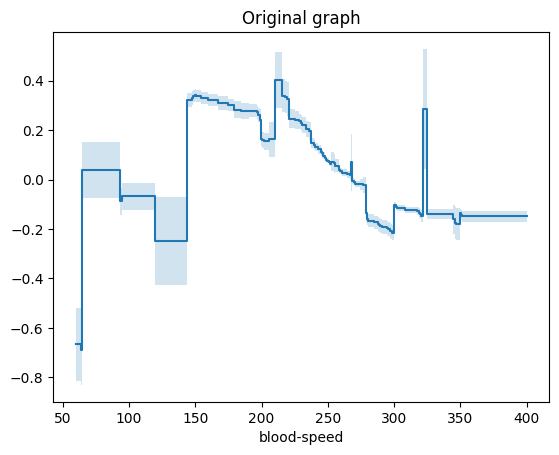

<Figure size 800x400 with 0 Axes>

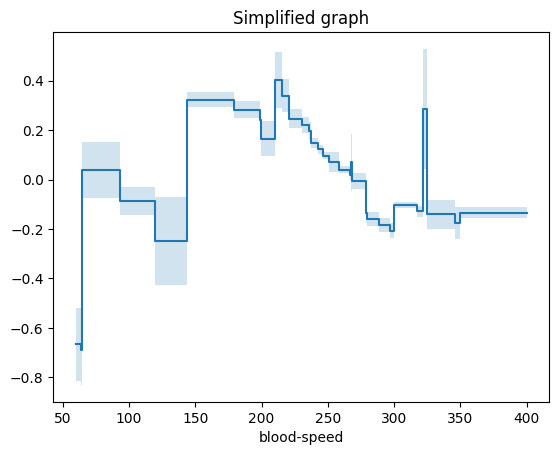

In [ ]:
from t2ebm.graphs import extract_graph, simplify_graph, plot_graph
import matplotlib.pyplot as plt

feature_idx = interpreter.feature_cols.index('Pre_HD_SBP')
graph = extract_graph(interpreter.model, feature_idx)
graph_simpl = simplify_graph(graph, min_variation_per_cent=0.02)  # 調整簡化強度

# 畫圖：原始 vs 簡化
plt.figure(figsize=(8,4))
plot_graph(graph)
plt.title("Original graph")
plt.show()

plt.figure(figsize=(8,4))
plot_graph(graph_simpl)
plt.title("Simplified graph")
plt.show()
